In [1]:
%run utils.ipynb

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [4]:
df=pd.read_csv("../data/train.csv")

In [5]:
#drop some useless columns
cols_to_drop=["Id","PID"]
df=df.drop(columns=cols_to_drop)

### The target label

In [6]:
df['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

Sale Price is non-zero and non-negative. So that is good.

Skew: 1.56


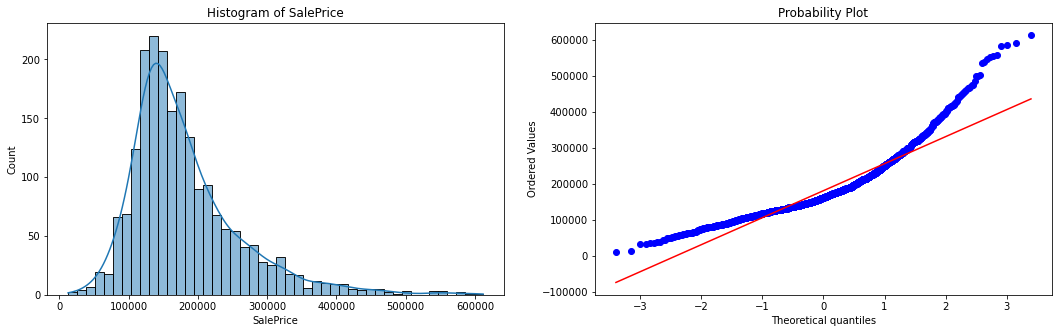

In [7]:
show_hist_qq(df,"SalePrice","Histogram of SalePrice")

This looks heavily right skewed and not normal distributed.  
Skew = 1.56. For a normal distribution, skew $\approx$ 0.  
This one has a moderate positive skew.  
Let's try to log this value.

In [8]:
df['log_SalePrice']=np.log(df['SalePrice'])

Skew: -0.15


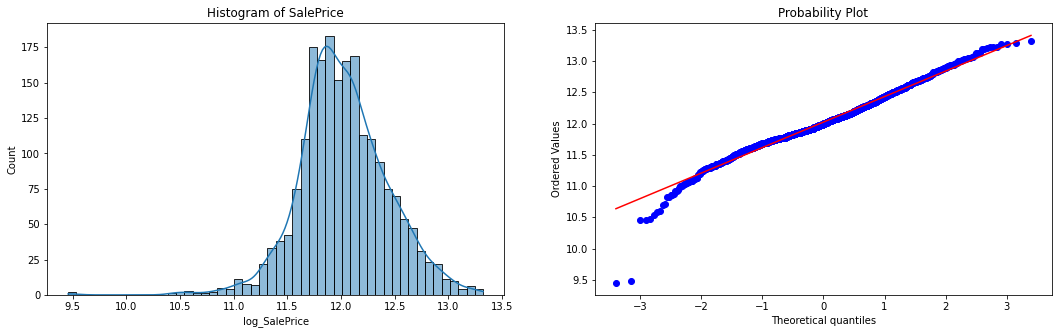

In [9]:
show_hist_qq(df,"log_SalePrice","Histogram of SalePrice")

This looks better.

#### Now let's do a basic comparison between `Gr Liv Area` and `SalePrice`

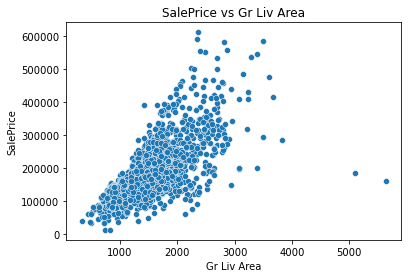

In [10]:
_,=sns.scatterplot(data=df,x="Gr Liv Area",y="SalePrice").set(title="SalePrice vs Gr Liv Area")

We do see a cone shape in the data, which suggests heteroscedasticity.  
Let us look at the logged `SalePrice`.

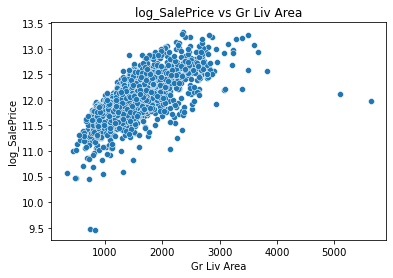

In [11]:
_,=sns.scatterplot(data=df,x="Gr Liv Area",y="log_SalePrice").set(title="log_SalePrice vs Gr Liv Area")

This looks better. The data points do not spread out in a conical shape as previous.  
We'll keep `log_SalePrice` and drop `SalePrice` hereon.

In [12]:
df=df.drop(columns="SalePrice")

### Preliminary feature selection

#### Let's study the correlation

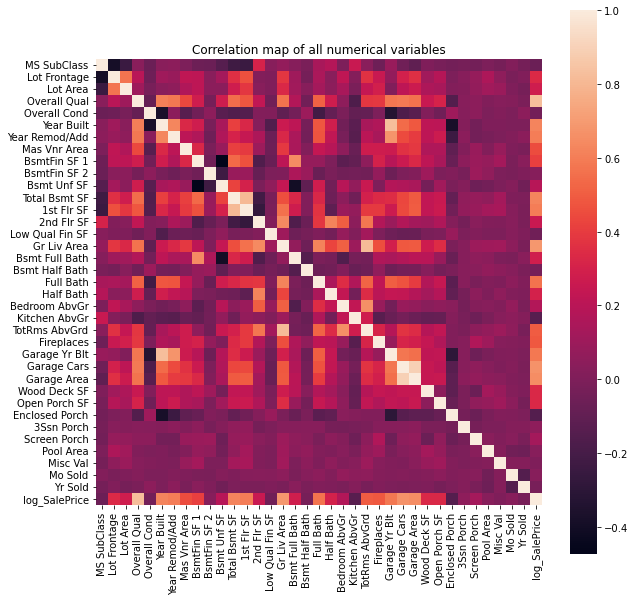

In [13]:
plt.rcParams['figure.figsize']=(10,10)
_=sns.heatmap(df.corr(),square=True).set(title="Correlation map of all numerical variables")

We do see a few variables having high correlation with each other. These should not be duplicated in the model later.  
`1st Flr SF` and `Total Bsmt SF`  
`Garage Yr Blt` and `Year Built`  
`TotRms AbvGrd` and `Gr Liv Area`  
`Garage Area` and `Garage Cars`

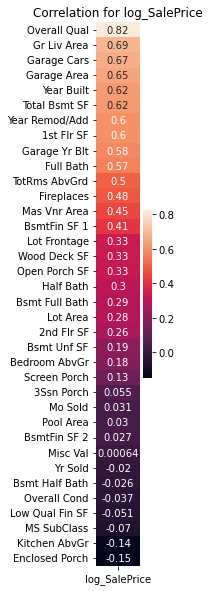

In [14]:
plt.rcParams['figure.figsize']=(1,10)
corrmap=df.corr()[['log_SalePrice']].sort_values(ascending=False,by="log_SalePrice").iloc[1:,:]
_=sns.heatmap(corrmap,annot=True).set(title="Correlation for log_SalePrice")

We do notice the few features with high correlation ($\ge$ 0.5) with `log_SalePrice` being:  
`Overall Qual`,`Gr Liv Area`, `Garage Cars`, `Garage Area`, `Year Built`, `Total Bsmt SF`, `Year Remod/Add`, `1st Flr SF`, `Garage Yr Blt`, `Full Bath`, and `TotRms AbvGrd`.


However, 4 of the 11 features shall be dropped due to high correlation with other features.  
Namely: `TotRms AbvGrd`,`Garage Area`, `Garage Yr Blt`,`1st Flr SF`.  
(We drop the lower correlating one and keep the higher correlating one).

We are left with 7 primary variables:  
`Overall Qual`, `Gr Liv Area`, `Garage Cars`, `Year Built`, `Total Bsmt SF`, `Year Remod/Add`, `Full Bath`.

In [15]:
cols_to_keep=['Overall Qual','Gr Liv Area','Garage Cars','Year Built','Total Bsmt SF','Year Remod/Add','Full Bath']
df_prelim=df[[*cols_to_keep,'log_SalePrice']]

#### Missing values

In [16]:
df_prelim.isnull().mean()*100

Overall Qual      0.000000
Gr Liv Area       0.000000
Garage Cars       0.048757
Year Built        0.000000
Total Bsmt SF     0.048757
Year Remod/Add    0.000000
Full Bath         0.000000
log_SalePrice     0.000000
dtype: float64

Only 0.05% of the dataset has missing data. Let's go ahead to drop those rows.

In [17]:
df_prelim=df_prelim.dropna().reset_index(drop=True)

### Set up model

In [18]:
#set up X and Y
X=df_prelim.drop(columns="log_SalePrice")
y=df_prelim["log_SalePrice"]

In [19]:
#fit a linear regression
lr=LR()
lr.fit(X,y)

LinearRegression()

In [20]:
#Look at Training RMSE
mean_squared_error(np.exp(y),np.exp(lr.predict(X)),squared=False)

48490.704843224274

### Try a submission

In [21]:
#Instantiate a copy of Tester helper class
tester=Tester("../data/test.csv")

In [22]:
#obtain a copy of the test set
df_test=tester.get_test_df()

In [23]:
#retain columns required for modelling
df_test=df_test[cols_to_keep]

In [24]:
#predict SalePrice. Remmber to np.exp to reverse the log.
ypred=np.exp(lr.predict(df_test))

In [25]:
tester.write_submission(ypred,"../data/01_prelim_submission.csv")

Output saved to ../data/01_prelim_submission.csv
